This notebook implements the Torrence and Compo wavelet analysis available at: https://github.com/chris-torrence/wavelets.

Let's import the relevant package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from scipy.special._ufuncs import gamma, gammainc
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

## Torrence and Compo Example - Nino 3.4

First, let's get the needed functionalities:

In [2]:
def wavelet(Y, dt, pad=0, dj=-1, s0=-1, J1=-1, mother=-1, param=-1, freq=None):
    
    '''
    WAVELET  1D Wavelet transform with optional significance testing
   wave, period, scale, coi = wavelet(Y, dt, pad, dj, s0, J1, mother, param)
   Computes the wavelet transform of the vector Y (length N),
   with sampling rate DT.

   By default, the Morlet wavelet (k0=6) is used.
   The wavelet basis is normalized to have total energy=1 at all scales.

 INPUTS:

    Y = the time series of length N.
    DT = amount of time between each Y value, i.e. the sampling time.

 OUTPUTS:

    WAVE is the WAVELET transform of Y. This is a complex array
    of dimensions (N,J1+1). FLOAT(WAVE) gives the WAVELET amplitude,
    ATAN(IMAGINARY(WAVE),FLOAT(WAVE) gives the WAVELET phase.
    The WAVELET power spectrum is ABS(WAVE)**2.
    Its units are sigma**2 (the time series variance).

 OPTIONAL INPUTS:

 *** Note *** if none of the optional variables is set up, then the program
   uses default values of -1.

    PAD = if set to 1 (default is 0), pad time series with zeroes to get
         N up to the next higher power of 2. This prevents wraparound
         from the end of the time series to the beginning, and also
         speeds up the FFT's used to do the wavelet transform.
         This will not eliminate all edge effects (see COI below).

    DJ = the spacing between discrete scales. Default is 0.25.
         A smaller # will give better scale resolution, but be slower to plot.

    S0 = the smallest scale of the wavelet.  Default is 2*DT.

    J1 = the # of scales minus one. Scales range from S0 up to S0*2**(J1*DJ),
        to give a total of (J1+1) scales. Default is J1 = (LOG2(N DT/S0))/DJ.

    MOTHER = the mother wavelet function.
             The choices are 'MORLET', 'PAUL', or 'DOG'

    PARAM = the mother wavelet parameter.
            For 'MORLET' this is k0 (wavenumber), default is 6.
            For 'PAUL' this is m (order), default is 4.
            For 'DOG' this is m (m-th derivative), default is 2.


 OPTIONAL OUTPUTS:

    PERIOD = the vector of "Fourier" periods (in time units) that corresponds
           to the SCALEs.

    SCALE = the vector of scale indices, given by S0*2**(j*DJ), j=0...J1
            where J1+1 is the total # of scales.

    COI = if specified, then return the Cone-of-Influence, which is a vector
        of N points that contains the maximum period of useful information
        at that particular time.
        Periods greater than this are subject to edge effects.

    '''
    
    n1 = len(Y)

    if s0 == -1:
        s0 = 2 * dt
    if dj == -1:
        dj = 1. / 4.
    if J1 == -1:
        J1 = np.fix((np.log(n1 * dt / s0) / np.log(2)) / dj)
    if mother == -1:
        mother = 'MORLET'

    # construct time series to analyze, pad if necessary
    x = Y - np.mean(Y)
    if pad == 1:
        # power of 2 nearest to N
        base2 = np.fix(np.log(n1) / np.log(2) + 0.4999)
        nzeroes = (2 ** (base2 + 1) - n1).astype(np.int64)
        x = np.concatenate((x, np.zeros(nzeroes)))

    n = len(x)

    # construct wavenumber array used in transform [Eqn(5)]
    kplus = np.arange(1, int(n / 2) + 1)
    kplus = (kplus * 2 * np.pi / (n * dt))
    kminus = np.arange(1, int((n - 1) / 2) + 1)
    kminus = np.sort((-kminus * 2 * np.pi / (n * dt)))
    k = np.concatenate(([0.], kplus, kminus))

    # compute FFT of the (padded) time series
    f = np.fft.fft(x)  # [Eqn(3)]

    # construct SCALE array & empty PERIOD & WAVE arrays
    if mother.upper() == 'MORLET':
        if param == -1:
            param = 6.
        fourier_factor = 4 * np.pi / (param + np.sqrt(2 + param**2))
    elif mother.upper() == 'PAUL':
        if param == -1:
            param = 4.
        fourier_factor = 4 * np.pi / (2 * param + 1)
    elif mother.upper() == 'DOG':
        if param == -1:
            param = 2.
        fourier_factor = 2 * np.pi * np.sqrt(2. / (2 * param + 1))
    else:
        fourier_factor = np.nan

    if freq is None:
        j = np.arange(0, J1 + 1)
        scale = s0 * 2. ** (j * dj)
        freq = 1. / (fourier_factor * scale)
        period = 1. / freq
    else:
        scale = 1. / (fourier_factor * freq)
        period = 1. / freq
    # define the wavelet array
    wave = np.zeros(shape=(len(scale), n), dtype=complex)

    # loop through all scales and compute transform
    for a1 in range(0, len(scale)):
        daughter, fourier_factor, coi, _ = \
            wave_bases(mother, k, scale[a1], param)
        wave[a1, :] = np.fft.ifft(f * daughter)  # wavelet transform[Eqn(4)]

    # COI [Sec.3g]
    coi = coi * dt * np.concatenate((
        np.insert(np.arange(int((n1 + 1) / 2) - 1), [0], [1E-5]),
        np.insert(np.flipud(np.arange(0, int(n1 / 2) - 1)), [-1], [1E-5])))
    wave = wave[:, :n1]  # get rid of padding before returning

    return wave, period, scale, coi

def wave_bases(mother, k, scale, param):
    '''
    WAVE_BASES  1D Wavelet functions Morlet, Paul, or DOG

  DAUGHTER,FOURIER_FACTOR,COI,DOFMIN = wave_bases(MOTHER,K,SCALE,PARAM)

   Computes the wavelet function as a function of Fourier frequency,
   used for the wavelet transform in Fourier space.
   (This program is called automatically by WAVELET)

 INPUTS:

    MOTHER = a string, equal to 'MORLET' or 'PAUL' or 'DOG'
    K = a vector, the Fourier frequencies at which to calculate the wavelet
    SCALE = a number, the wavelet scale
    PARAM = the nondimensional parameter for the wavelet function

 OUTPUTS:

    DAUGHTER = a vector, the wavelet function
    FOURIER_FACTOR = the ratio of Fourier period to scale
    COI = a number, the cone-of-influence size at the scale
    DOFMIN = a number, degrees of freedom for each point in the wavelet power
             (either 2 for Morlet and Paul, or 1 for the DOG)
    '''
    n = len(k)
    kplus = np.array(k > 0., dtype=float)

    if mother == 'MORLET':  # -----------------------------------  Morlet

        if param == -1:
            param = 6.

        k0 = np.copy(param)
        # calc psi_0(s omega) from Table 1
        expnt = -(scale * k - k0) ** 2 / 2. * kplus
        norm = np.sqrt(scale * k[1]) * (np.pi ** (-0.25)) * np.sqrt(n)
        daughter = norm * np.exp(expnt)
        daughter = daughter * kplus  # Heaviside step function
        # Scale-->Fourier [Sec.3h]
        fourier_factor = (4 * np.pi) / (k0 + np.sqrt(2 + k0 ** 2))
        coi = fourier_factor / np.sqrt(2)  # Cone-of-influence [Sec.3g]
        dofmin = 2  # Degrees of freedom
    elif mother == 'PAUL':  # --------------------------------  Paul
        if param == -1:
            param = 4.
        m = param
        # calc psi_0(s omega) from Table 1
        expnt = -scale * k * kplus
        norm_bottom = np.sqrt(m * np.prod(np.arange(1, (2 * m))))
        norm = np.sqrt(scale * k[1]) * (2 ** m / norm_bottom) * np.sqrt(n)
        daughter = norm * ((scale * k) ** m) * np.exp(expnt) * kplus
        fourier_factor = 4 * np.pi / (2 * m + 1)
        coi = fourier_factor * np.sqrt(2)
        dofmin = 2
    elif mother == 'DOG':  # --------------------------------  DOG
        if param == -1:
            param = 2.
        m = param
        # calc psi_0(s omega) from Table 1
        expnt = -(scale * k) ** 2 / 2.0
        norm = np.sqrt(scale * k[1] / gamma(m + 0.5)) * np.sqrt(n)
        daughter = -norm * (1j ** m) * ((scale * k) ** m) * np.exp(expnt)
        fourier_factor = 2 * np.pi * np.sqrt(2. / (2 * m + 1))
        coi = fourier_factor / np.sqrt(2)
        dofmin = 1
    else:
        print('Mother must be one of MORLET, PAUL, DOG')

    return daughter, fourier_factor, coi, dofmin

def wave_signif(Y, dt, scale, sigtest=0, lag1=0.0, siglvl=0.95,
                dof=None, mother='MORLET', param=None, gws=None):
    
    '''
    # --------------------------------------------------------------------------
 WAVE_SIGNIF  Significance testing for the 1D Wavelet transform WAVELET

   SIGNIF = wave_signif(Y,DT,SCALE,SIGTEST,LAG1,SIGLVL,DOF,MOTHER,PARAM)

 INPUTS:

    Y = the time series, or, the VARIANCE of the time series.
        (If this is a single number, it is assumed to be the variance...)
    DT = amount of time between each Y value, i.e. the sampling time.
    SCALE = the vector of scale indices, from previous call to WAVELET.


 OUTPUTS:

    SIGNIF = significance levels as a function of SCALE
    FFT_THEOR = output theoretical red-noise spectrum as fn of PERIOD


 OPTIONAL INPUTS:
    SIGTEST = 0, 1, or 2.    If omitted, then assume 0.

         If 0 (the default), then just do a regular chi-square test,
             i.e. Eqn (18) from Torrence & Compo.
         If 1, then do a "time-average" test, i.e. Eqn (23).
             In this case, DOF should be set to NA, the number
             of local wavelet spectra that were averaged together.
             For the Global Wavelet Spectrum, this would be NA=N,
             where N is the number of points in your time series.
         If 2, then do a "scale-average" test, i.e. Eqns (25)-(28).
             In this case, DOF should be set to a
             two-element vector [S1,S2], which gives the scale
             range that was averaged together.
             e.g. if one scale-averaged scales between 2 and 8,
             then DOF=[2,8].

    LAG1 = LAG 1 Autocorrelation, used for SIGNIF levels. Default is 0.0

    SIGLVL = significance level to use. Default is 0.95

    DOF = degrees-of-freedom for signif test.
         IF SIGTEST=0, then (automatically) DOF = 2 (or 1 for MOTHER='DOG')
         IF SIGTEST=1, then DOF = NA, the number of times averaged together.
         IF SIGTEST=2, then DOF = [S1,S2], the range of scales averaged.

       Note: IF SIGTEST=1, then DOF can be a vector (same length as SCALEs),
            in which case NA is assumed to vary with SCALE.
            This allows one to average different numbers of times
            together at different scales, or to take into account
            things like the Cone of Influence.
            See discussion following Eqn (23) in Torrence & Compo.

    GWS = global wavelet spectrum, a vector of the same length as scale.
          If input then this is used as the theoretical background spectrum,
          rather than white or red noise.
    '''
    
    n1 = len(np.atleast_1d(Y))
    J1 = len(scale) - 1
    dj = np.log2(scale[1] / scale[0])

    if n1 == 1:
        variance = Y
    else:
        variance = np.std(Y) ** 2

    # get the appropriate parameters [see Table(2)]
    if mother == 'MORLET':  # ----------------------------------  Morlet
        empir = ([2., -1, -1, -1])
        if param is None:
            param = 6.
            empir[1:] = ([0.776, 2.32, 0.60])
        k0 = param
        # Scale-->Fourier [Sec.3h]
        fourier_factor = (4 * np.pi) / (k0 + np.sqrt(2 + k0 ** 2))
    elif mother == 'PAUL':
        empir = ([2, -1, -1, -1])
        if param is None:
            param = 4
            empir[1:] = ([1.132, 1.17, 1.5])
        m = param
        fourier_factor = (4 * np.pi) / (2 * m + 1)
    elif mother == 'DOG':  # -------------------------------------Paul
        empir = ([1., -1, -1, -1])
        if param is None:
            param = 2.
            empir[1:] = ([3.541, 1.43, 1.4])
        elif param == 6:  # --------------------------------------DOG
            empir[1:] = ([1.966, 1.37, 0.97])
        m = param
        fourier_factor = 2 * np.pi * np.sqrt(2. / (2 * m + 1))
    else:
        print('Mother must be one of MORLET, PAUL, DOG')

    period = scale * fourier_factor
    dofmin = empir[0]  # Degrees of freedom with no smoothing
    Cdelta = empir[1]  # reconstruction factor
    gamma_fac = empir[2]  # time-decorrelation factor
    dj0 = empir[3]  # scale-decorrelation factor

    freq = dt / period  # normalized frequency

    if gws is not None:   # use global-wavelet as background spectrum
        fft_theor = gws
    else:
        # [Eqn(16)]
        fft_theor = (1 - lag1 ** 2) / \
            (1 - 2 * lag1 * np.cos(freq * 2 * np.pi) + lag1 ** 2)
        fft_theor = variance * fft_theor  # include time-series variance

    signif = fft_theor
    if dof is None:
        dof = dofmin

    if sigtest == 0:  # no smoothing, DOF=dofmin [Sec.4]
        dof = dofmin
        chisquare = chisquare_inv(siglvl, dof) / dof
        signif = fft_theor * chisquare  # [Eqn(18)]
    elif sigtest == 1:  # time-averaged significance
        if len(np.atleast_1d(dof)) == 1:
            dof = np.zeros(J1) + dof
        dof[dof < 1] = 1
        # [Eqn(23)]
        dof = dofmin * np.sqrt(1 + (dof * dt / gamma_fac / scale) ** 2)
        dof[dof < dofmin] = dofmin   # minimum DOF is dofmin
        for a1 in range(0, J1 + 1):
            chisquare = chisquare_inv(siglvl, dof[a1]) / dof[a1]
            signif[a1] = fft_theor[a1] * chisquare
    elif sigtest == 2:  # time-averaged significance
        if len(dof) != 2:
            print('ERROR: DOF must be set to [S1,S2],'
                ' the range of scale-averages')
        if Cdelta == -1:
            print('ERROR: Cdelta & dj0 not defined'
                  ' for ' + mother + ' with param = ' + str(param))

        s1 = dof[0]
        s2 = dof[1]
        avg = np.logical_and(scale >= 2, scale < 8)  # scales between S1 & S2
        navg = np.sum(np.array(np.logical_and(scale >= 2, scale < 8),
            dtype=int))
        if navg == 0:
            print('ERROR: No valid scales between ' + s1 + ' and ' + s2)
        Savg = 1. / np.sum(1. / scale[avg])  # [Eqn(25)]
        Smid = np.exp((np.log(s1) + np.log(s2)) / 2.)  # power-of-two midpoint
        dof = (dofmin * navg * Savg / Smid) * \
            np.sqrt(1 + (navg * dj / dj0) ** 2)  # [Eqn(28)]
        fft_theor = Savg * np.sum(fft_theor[avg] / scale[avg])  # [Eqn(27)]
        chisquare = chisquare_inv(siglvl, dof) / dof
        signif = (dj * dt / Cdelta / Savg) * fft_theor * chisquare  # [Eqn(26)]
    else:
        print('ERROR: sigtest must be either 0, 1, or 2')

    return signif

def chisquare_inv(P, V):
    '''
    # CHISQUARE_INV  Inverse of chi-square cumulative distribution function (cdf).
#
#   X = chisquare_inv(P,V) returns the inverse of chi-square cdf with V
#   degrees of freedom at fraction P.
#   This means that P*100 percent of the distribution lies between 0 and X.
#
#   To check, the answer should satisfy:   P==gammainc(X/2,V/2)

# Uses FMIN and CHISQUARE_SOLVE
'''

    if (1 - P) < 1E-4:
        print('P must be < 0.9999')

    if P == 0.95 and V == 2:  # this is a no-brainer
        X = 5.9915
        return X

    MINN = 0.01  # hopefully this is small enough
    MAXX = 1  # actually starts at 10 (see while loop below)
    X = 1
    TOLERANCE = 1E-4  # this should be accurate enough

    while (X + TOLERANCE) >= MAXX:  # should only need to loop thru once
        MAXX = MAXX * 10.
    # this calculates value for X, NORMALIZED by V
        X = fminbound(chisquare_solve, MINN, MAXX, args=(P, V), xtol=TOLERANCE)
        MINN = MAXX

    X = X * V  # put back in the goofy V factor

    return X  # end of code

def chisquare_solve(XGUESS, P, V):
    '''
    
       PDIFF=chisquare_solve(XGUESS,P,V)  Given XGUESS, a percentile P,
       and degrees-of-freedom V, return the difference between
       calculated percentile and P.

     Uses GAMMAINC
    
     Written January 1998 by C. Torrence

     extra factor of V is necessary because X is Normalized
    '''

    PGUESS = gammainc(V / 2, V * XGUESS / 2)  # incomplete Gamma function

    PDIFF = np.abs(PGUESS - P)            # error in calculated P

    TOL = 1E-4
    if PGUESS >= 1 - TOL:  # if P is very close to 1 (i.e. a bad guess)
        PDIFF = XGUESS   # then just assign some big number like XGUESS

    return PDIFF

Run their example as is for reproducibility:

lag1 =  0.72


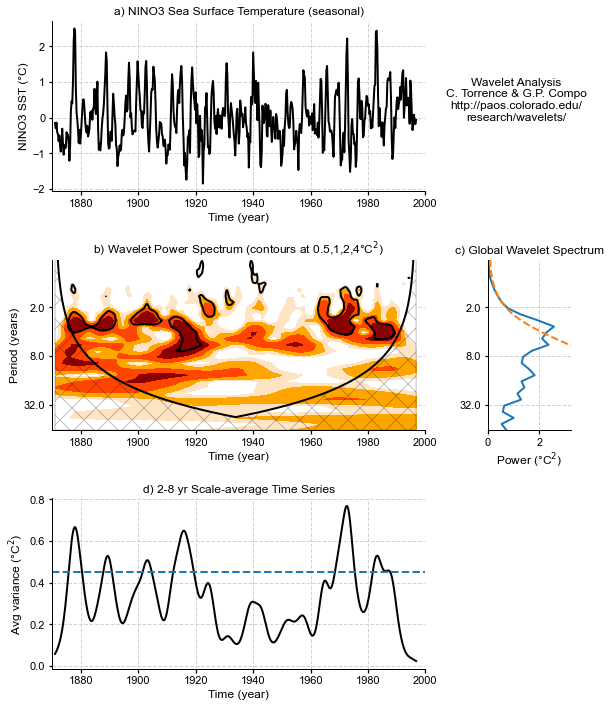

In [32]:
sst = np.loadtxt('sst_nino3.dat')  # input SST time series
sst = sst - np.mean(sst)
variance = np.std(sst, ddof=1) ** 2

if 0:
    variance = 1.0
    sst = sst / np.std(sst, ddof=1)
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # construct time array
xlim = ([1870, 2000])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
amplitude=np.abs(wave)
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times
global_ws_amplitude = (np.sum(amplitude, axis=1) / n)

# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
    lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant

# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

# Scale-average between El Nino periods of 2--8 years [MAYBE REMOVE?]
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
# expand scale --> (J+1)x(N) array
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

# ------------------------------------------------------ Plotting

# --- Plot time series
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                    wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(time, sst, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (\u00B0C)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

plt.text(time[-1] + 35, 0.5, 'Wavelet Analysis\nC. Torrence & G.P. Compo\n'
    'http://paos.colorado.edu/\nresearch/wavelets/',
    horizontalalignment='center', verticalalignment='center')

# --- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3])
levels = [0, 0.5, 1, 2, 4, 999]
# *** or use 'contour'
CS = plt.contourf(time, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (year)')
plt.ylabel('Period (years)')
plt.title('b) Wavelet Power Spectrum (contours at 0.5,1,2,4\u00B0C$^2$)')
plt.xlim(xlim[:])
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(time, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(time, coi, 'k')
# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()
# set up the size and location of the colorbar
# position=fig.add_axes([0.5,0.36,0.2,0.01])
# plt.colorbar(im, cax=position, orientation='horizontal')
#   , fraction=0.05, pad=0.5)

# plt.subplots_adjust(right=0.7, top=0.9)

# --- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (\u00B0C$^2$)')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

# --- Plot 2--8 yr scale-average time series
plt.subplot(gs[2, 0:3])
plt.plot(time, scale_avg, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('Avg variance (\u00B0C$^2$)')
plt.title('d) 2-8 yr Scale-average Time Series')
plt.plot(xlim, scaleavg_signif + [0, 0], '--')

plt.show()

Make the scalogram plot in Pyleoclim for comparison

In [4]:
import pyleoclim as pyleo

In [27]:
scal = pyleo.Scalogram(1/period, time, np.abs(wave).T)
scal_power = pyleo.Scalogram(1/period, time,power.T)

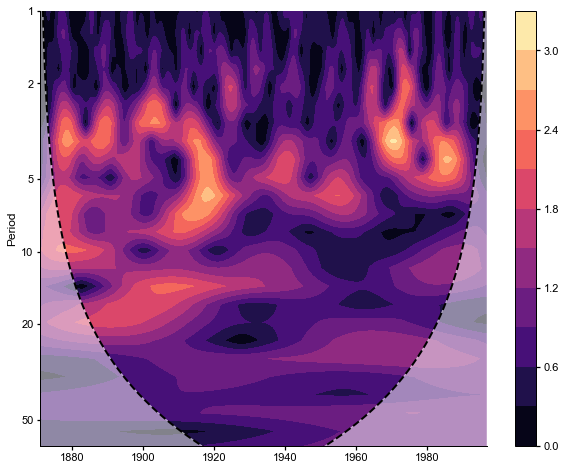

In [11]:
fig,ax = scal.plot()
ax.set_ylim([1, 64])
ax.invert_yaxis()

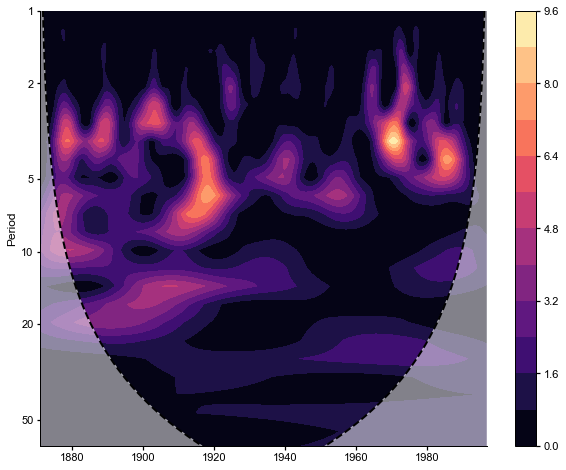

In [28]:
fig,ax = scal_power.plot()
ax.set_ylim([1, 64])
ax.invert_yaxis()

Get the scalogram from wwz:

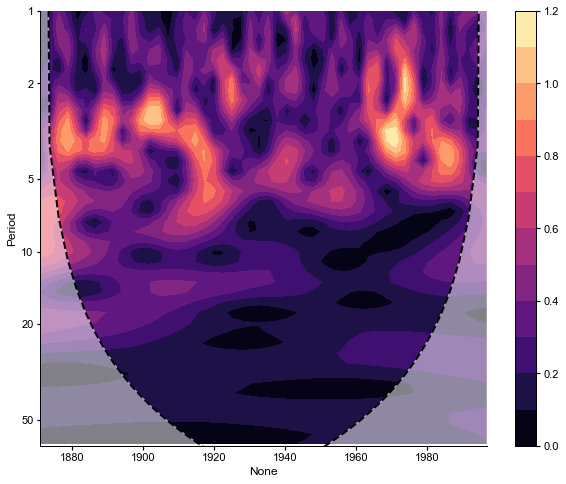

In [37]:
ts=pyleo.Series(time,sst)
scal_wwz = ts.standardize().wavelet()
fig,ax = scal_wwz.plot()
ax.set_ylim([1, 64])
ax.invert_yaxis()

Obtained PSD for both and compare

In [38]:
psd_tp = pyleo.PSD(1/period,global_ws,label='TP')
psd_tp_amp = pyleo.PSD(1/period,global_ws_amplitude,label='TP-amplitude')
psd_wwz=ts.standardize().spectral(method='wwz')
psd_fromscal = ts.standardize().spectral(method='wwz',scalogram=scal_wwz)

<AxesSubplot:xlabel='Period', ylabel='PSD'>

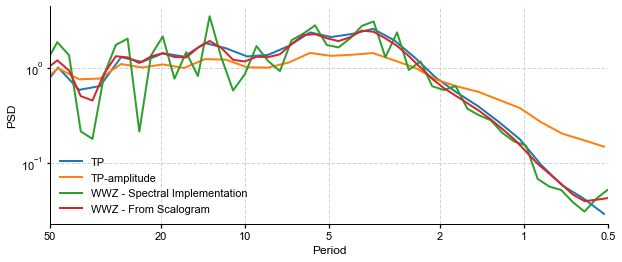

In [39]:
fig,ax = psd_tp.plot()
psd_tp_amp.plot(ax=ax)
psd_wwz.plot(ax=ax,label='WWZ - Spectral Implementation')
psd_fromscal.plot(ax=ax, label ='WWZ - From Scalogram')

Use the frequency methods available in Pyleoclim:

In [29]:
freq_log = pyleo.utils.wavelet.make_freq_vector(time,method='log')
freq_ls = pyleo.utils.wavelet.make_freq_vector(time,method='lomb_scargle')
freq_welch = pyleo.utils.wavelet.make_freq_vector(time,method='welch')
freq_nfft = pyleo.utils.wavelet.make_freq_vector(time,method='nfft')
freq_scale = pyleo.utils.wavelet.make_freq_vector(time,method='scale')

freq_label = ['log','lomb_scargle','welch','nfft','scale']
freq = [freq_log, freq_ls, freq_welch,freq_nfft,freq_scale]

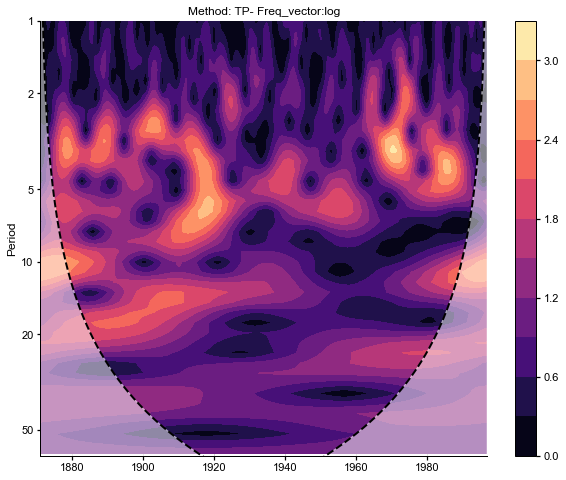

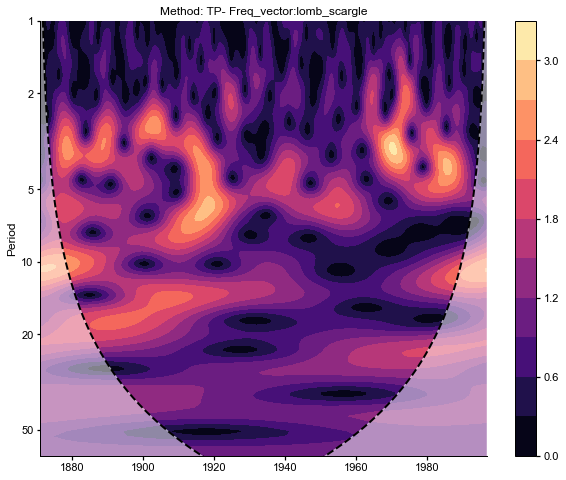

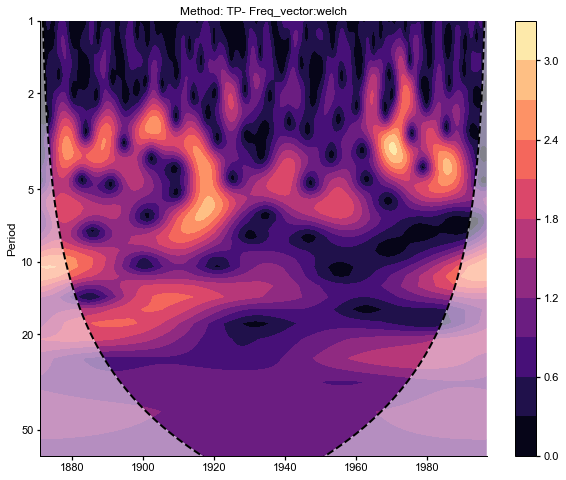

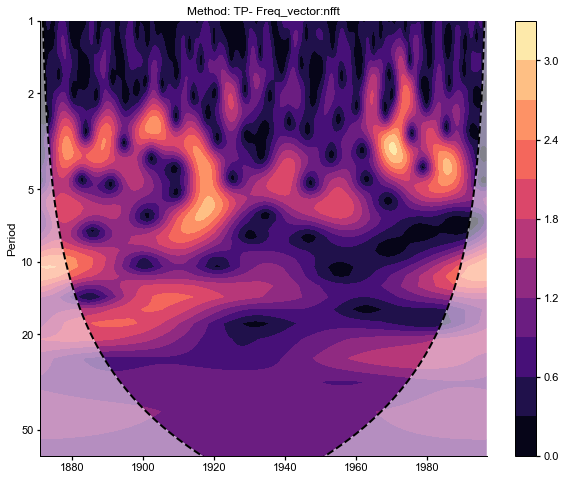

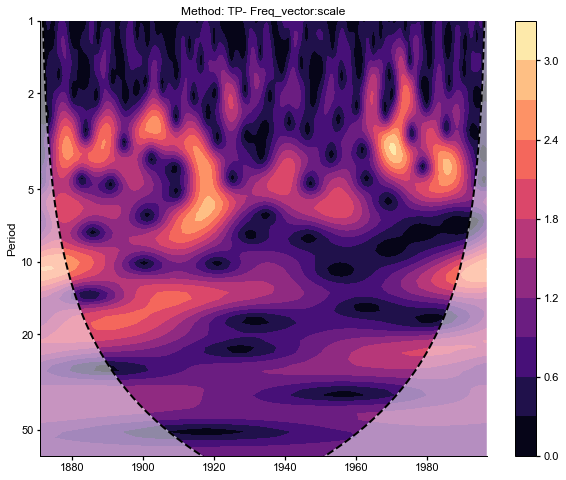

In [31]:
for idx, item in enumerate(freq):
    try:
        wave, period, scale, coi = wavelet(sst, dt, freq=item)
        amplitude = (abs(wave)) #this is what is returned by TP and WWZ in Pyleoclim

        scal_pwt = pyleo.Scalogram(1/period, time, amplitude.T)
        fig, ax = scal_pwt.plot(mute=True)
        ax.set_ylim([1, 64])
        ax.set_title('Method: TP- Freq_vector:'+freq_label[idx])
        ax.invert_yaxis()
        pyleo.showfig(fig)
        pyleo.closefig()
    except:
        print('Method returns error with chosen freq vector')